# [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) | DLology

Read my blog post for details.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
np.random.seed(10)

2022-12-09 17:54:50.358153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 17:54:50.977766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda-10.1/targets/x86_64-linux/lib/:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-10.1/targets/x86_64-linux/lib/:/usr/local/cuda/extras/CUPTI/lib64
2022-12-09 17:54:50.977838: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_

In [2]:
from time import time
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics



In [3]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [5]:
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

## Base line K-Means clustering accuracy

In [6]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)#, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

In [7]:
metrics.acc(y, y_pred_kmeans)

/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


0.5322857142857143

## Hyper-params

In [8]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

2022-12-09 17:57:35.214655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 17:57:36.011495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5292 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
2022-12-09 17:57:36.011929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5372 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1


In [9]:
autoencoder, encoder = autoencoder(dims, init=init)

/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


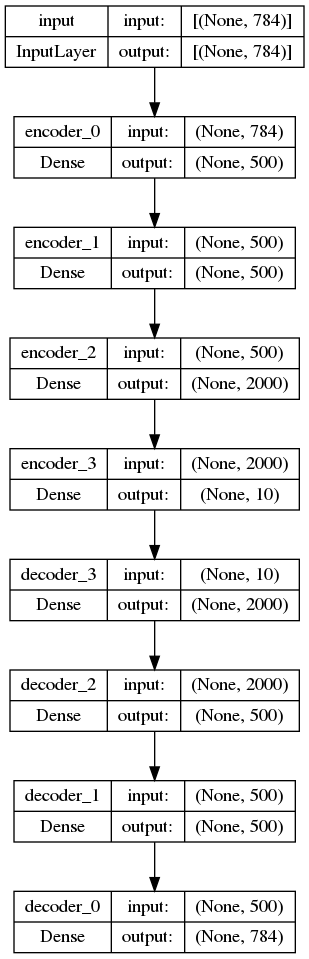

In [10]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

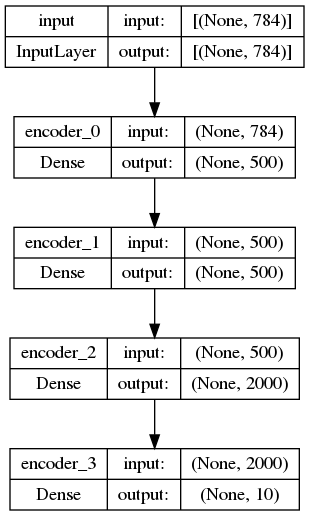

In [11]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

## Pretrain auto-encoder

In [12]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/300


2022-12-09 17:57:37.759889: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efc6c017720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-09 17:57:37.759919: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2022-12-09 17:57:37.759925: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2022-12-09 17:57:37.771782: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-09 17:57:37.797411: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 [==============================] - 2s 5ms/step - loss: 0.1091
Epoch 2/300
274/274 [==============================] - 1s 5ms/step - loss: 0.1024
Epoch 3/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0951
Epoch 4/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0779
Epoch 5/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0653
Epoch 6/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0642
Epoch 7/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0639
Epoch 8/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0638
Epoch 9/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0637
Epoch 10/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0636
Epoch 11/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0635
Epoch 12/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0635
Epoch 13/300
274/274 [===

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = './results/ae_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights

In [ ]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering model

### ClusteringLayer

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [ ]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### Break down Accuracy metric

linear assignment- [Munkres' Assignment Algorithm](http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html)

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
w

In [ ]:
ind

In [ ]:
w.argmax(1)

## Experimental
Convolutional auto encoder.

In [ ]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

### Convolutional auto encoder option 1
Use [`Conv2DTranspose`](https://keras.io/layers/convolutional/#conv2dtranspose) to reconstruct the image.

In [ ]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Convolutional auto encoder option 2
Use [`UpSampling2D`](https://keras.io/layers/convolutional/#upsampling2d) to reconstruct the image.

In [ ]:
def autoencoderConv2D_2(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


### Pick a convolutional autoencoder
`autoencoderConv2D_1` or `autoencoderConv2D_2`

In [ ]:
autoencoder, encoder = autoencoderConv2D_1()

In [ ]:
autoencoder.summary()

### Load MNIST data for convolutional input

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

### Pretrain covolutional autoencoder

In [ ]:
pretrain_epochs = 100
batch_size = 256

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

In [ ]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

### Build clustering model with convolutional autoencoder

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering

In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [ ]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Convolutional)
Multiple outputs model.

In [ ]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


### Initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

In [ ]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

### Initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()